## Data Cleaning & EDA

In [48]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import regex as re

sns.set_style(style = 'whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Import Data

In [49]:
df = pickle.load(open("../assets/combined_subreddits.pkl", "rb"))

In [50]:
df.head()

,title,selftext,title_self_text,created_utc,subreddit
0,Late Night Laundry,[removed],Late Night Laundry[removed],1580239970,nosleep
1,Why Did The Moon Disappear? [Part One],[removed],Why Did The Moon Disappear? [Part One][removed],1580239486,nosleep
2,You don't die of old age (Part 1),[removed],You don't die of old age (Part 1)[removed],1580239395,nosleep
3,Why Did The Moon Disappear? [True Story] (part...,[removed],Why Did The Moon Disappear? [True Story] (part...,1580238771,nosleep
4,The Door To Hell,NaN,NaN,1580237605,nosleep


Drops any duplicate obserevations and resets index afterwards.

In [51]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

#### Create a filler for missing values. Will be removed later!

In [52]:
nan_filler = 'DELETE_THIS_PLACEhHOLDER_SUPER_OBScURE-492929435'
df.fillna(value = nan_filler, inplace = True)

In [53]:
df.isnull().sum().sum()

0

#### Create new column `all_text` that combines `title` and `selftext` columns.
- Since I combined the `title` and `selftext` columns when creating the DataFrame, the observations whose `selftext` was removed, contained an image, or contained a video appeared as missing values.
- I handled these missing values by creating a placeholder for them and adding a new column `all_text` that combined the `title` and `selftext` in a cleaner way than I had done before.
- Because of the placeholder, the missing values didn't transfer to the new column, which was the goal. Lastly, I removed the filler values and was left with a clean `all_text` column on which to use as a feature for the model.

In [54]:
df['all_text'] = df['title'] + ' ' + df['selftext']

In [55]:
df['all_text'] = df['all_text'].str.replace(nan_filler, '')
df['all_text'].isnull().sum()

0

In [56]:
# Drop excess columns
df.drop(columns=['title', 'selftext', 'title_self_text'], inplace=True)

#### Create new columns `char_count` and `word_count` to look at distributions.
- I created two columns, `char_count` and `word_count` using a lambda function that map to each observation in `all_text` and, respectively, 1) calculates the item length and 2) splits the item and calculates its length. 
- I filtered through the DataFrame and identified observations whose `char_count` was less than 10 and dropped them from the DataFrame because there are few enough where it won't make a difference in the model.

In [57]:
# Create new columns char_count and word_count to look at distributions
df['char_count'] = df['all_text'].map(lambda x: len(x))

df['word_count'] = df['all_text'].map(lambda x: len(x.split()))

# Drop rows whose character count value is less than 10
df.drop(df[df['char_count'] < 10].index, inplace=True)

df.head()

,created_utc,subreddit,all_text,char_count,word_count
0,1580239970,nosleep,Late Night Laundry [removed],28,4
1,1580239486,nosleep,Why Did The Moon Disappear? [Part One] [removed],48,8
2,1580239395,nosleep,You don't die of old age (Part 1) [removed],43,9
3,1580238771,nosleep,Why Did The Moon Disappear? [True Story] (part...,61,10
4,1580237605,nosleep,The Door To Hell,17,4


In [58]:
df.shape

(19798, 5)

In [59]:
# Rearrange order of columns (just a preference)
df = df.reindex(columns=['all_text', 'subreddit', 'char_count', 'word_count', 'created_utc'])

In [60]:
df.head()

,all_text,subreddit,char_count,word_count,created_utc
0,Late Night Laundry [removed],nosleep,28,4,1580239970
1,Why Did The Moon Disappear? [Part One] [removed],nosleep,48,8,1580239486
2,You don't die of old age (Part 1) [removed],nosleep,43,9,1580239395
3,Why Did The Moon Disappear? [True Story] (part...,nosleep,61,10,1580238771
4,The Door To Hell,nosleep,17,4,1580237605


#### Assign target (subreddit) values.

In [61]:
df['subreddit'].value_counts()

nosleep        9991
creepypasta    9807
Name: subreddit, dtype: int64

In [62]:
# Replace subreddit target to 'nosleep':1 and 'creepypasta' :0
df['subreddit'] = [1 if i == 'nosleep' else 0 for i in df['subreddit']]
df['subreddit'].value_counts()

1    9991
0    9807
Name: subreddit, dtype: int64

### Character & Word Distributions

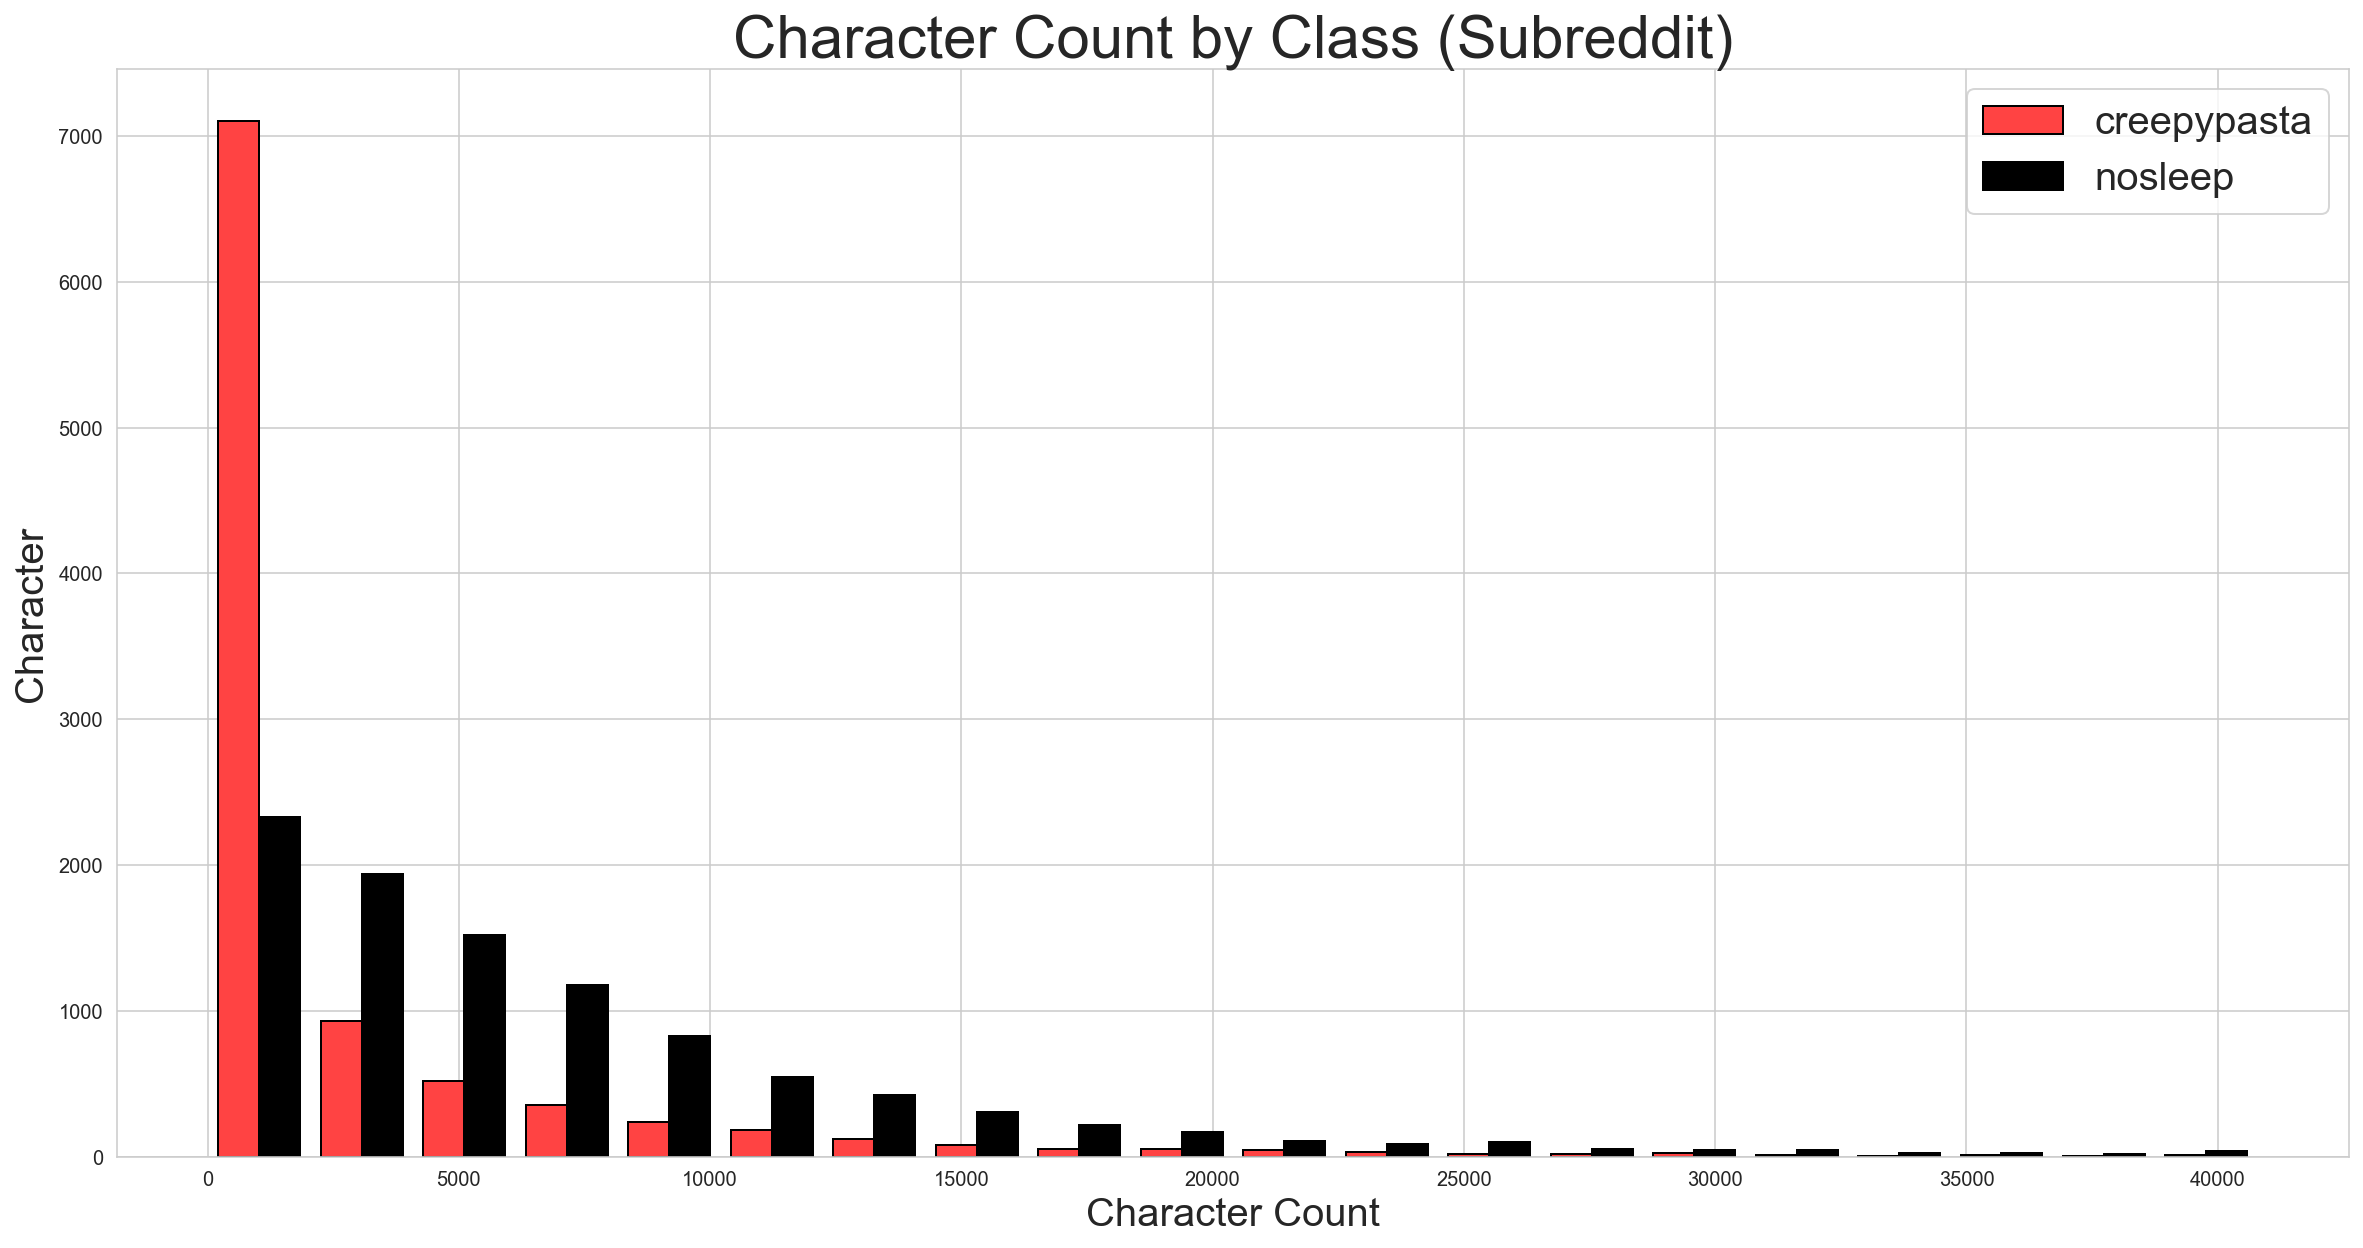

In [63]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['char_count'], 
          df[df['subreddit']==1]['char_count']],
         bins=20, color=['#FF4343', 'black'], ec='k')
plt.title('Character Count by Class (Subreddit)', fontsize=30)
plt.xlabel('Character Count', fontsize =20)
plt.ylabel('Character', fontsize =20)
plt.legend(['creepypasta', 'nosleep'], fontsize =20);

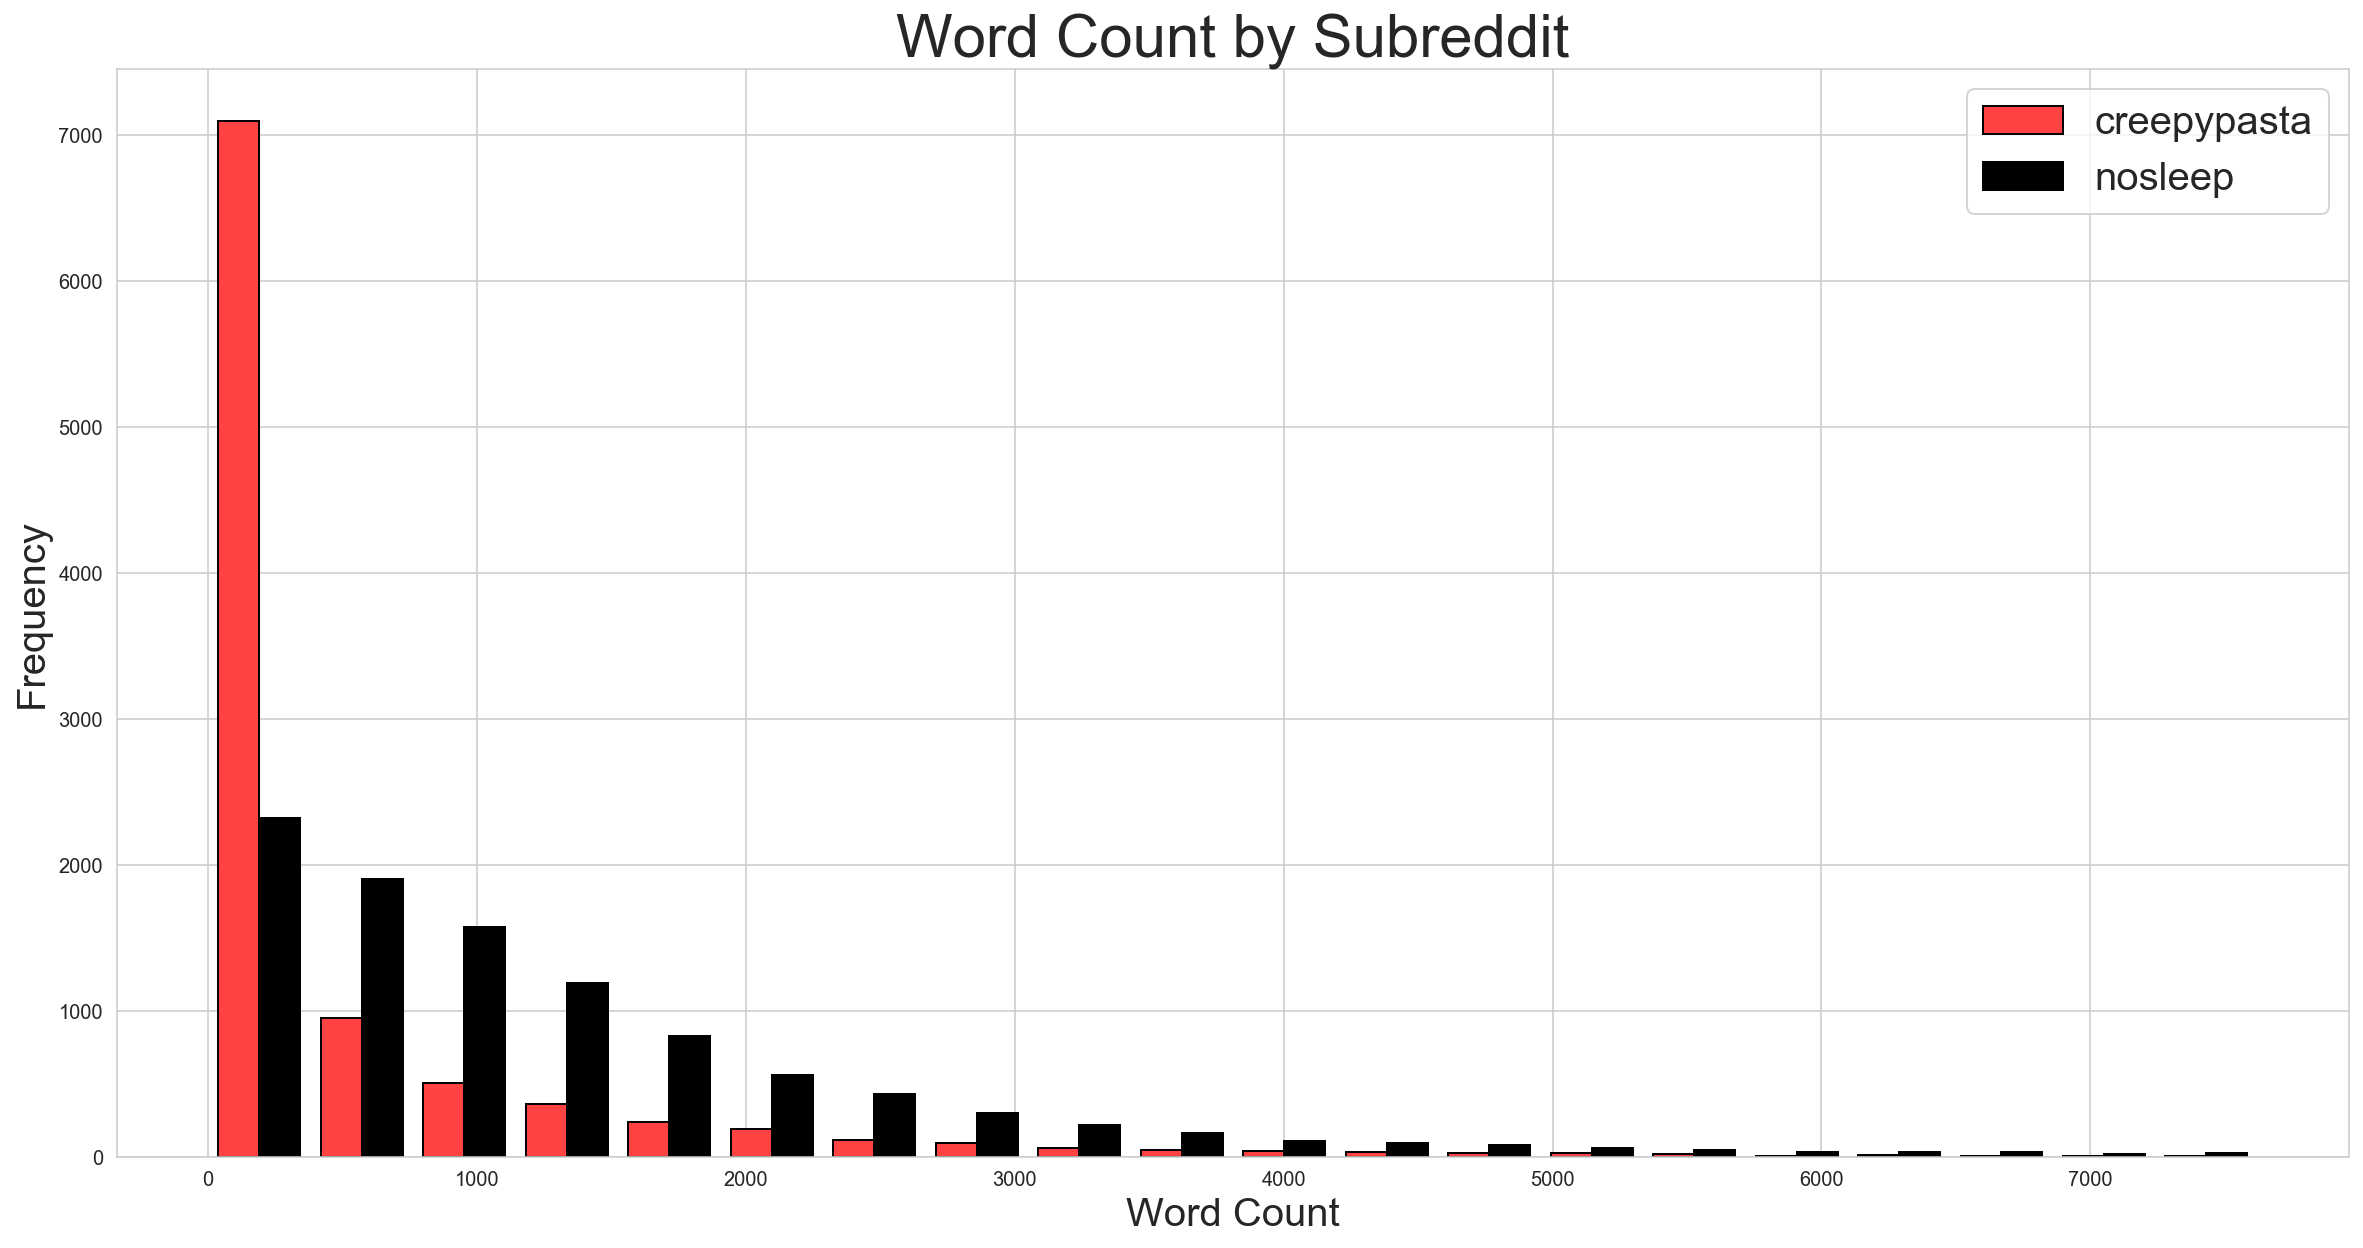

In [64]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['word_count'], 
          df[df['subreddit']==1]['word_count']],
         bins=20, color=['#FF4343', 'black'], ec='k')
plt.title('Word Count by Subreddit', fontsize=30)
plt.xlabel('Word Count', fontsize =20)
plt.ylabel('Frequency', fontsize =20)
plt.legend(['creepypasta', 'nosleep'], fontsize =20);
plt.savefig('../images/word_count.png')

In [65]:
df.groupby('subreddit')[['word_count']].mean()

,word_count
subreddit,
0,447.454165
1,1274.076469


>On average, [`/r/creepypasta's`](https://www.reddit.com/r/creepypasta) posts are shorter than [`/r/nosleep's`](https://www.reddit.com/r/nosleep) posts.

Create subreddit dataframes to look at outliers in each target.

In [66]:
sub1 = df[df['subreddit'] == 1]
sub0 = df[df['subreddit'] == 0] 

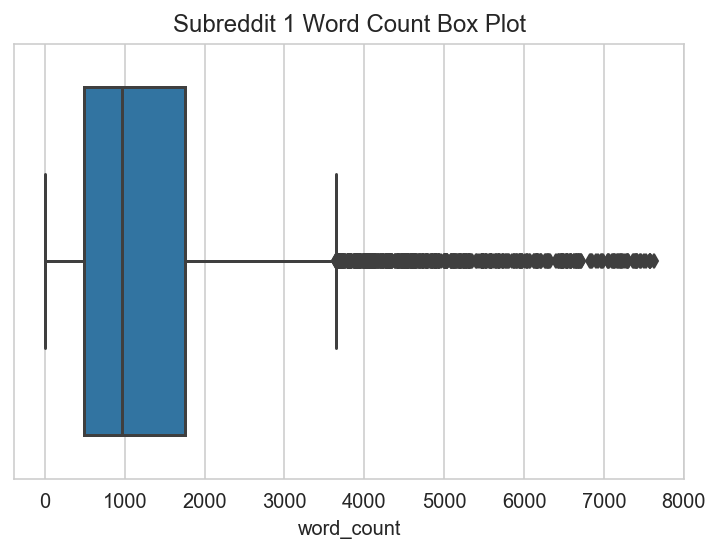

In [67]:
sns.boxplot(sub1['word_count']);
plt.title('Subreddit 1 Word Count Box Plot');

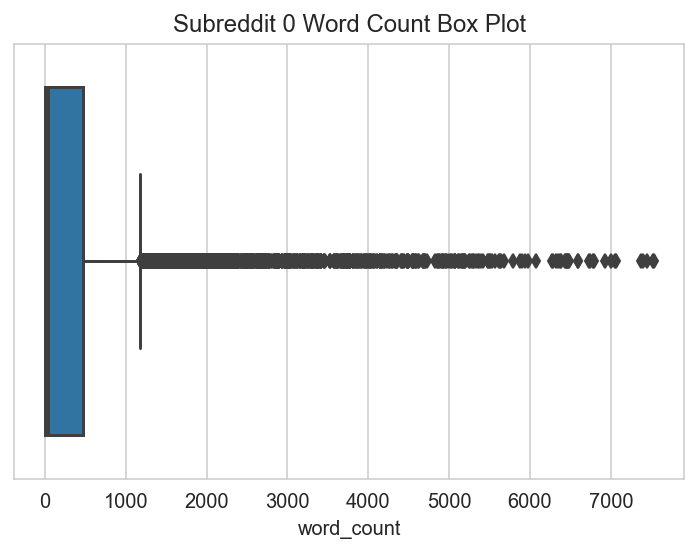

In [68]:
sns.boxplot(sub0['word_count']);
plt.title('Subreddit 0 Word Count Box Plot');

>While there are a lot of outliers in the word count of each subreddit, I will keep them because it will be relevant for training the model.

### Clean `all_text`:
- Using regular expressions, `.re()`, I was able to remove much "noise" such as: line breaks, punctuation, subreddit mentions, consecutive letters that mimic sounds, from `all_text` to improve the model.


In [69]:
# Reset indices
df.reset_index(drop=True, inplace=True)

In [70]:
# Remove '[removed]' which occurs when the selftext was removed from the subreddit
df['all_text'] = df['all_text'].str.replace('\[removed\]', '')

# Check that '[removed]' was removed
df['all_text'].str.contains('\[removed\]').sum()

# Make all_text column lowercase
df['all_text'] = df['all_text'].map(lambda x: str.lower(x))

# Remove target subreddit from all_text
df['all_text'] = df['all_text'].str.replace('nosleep', '')
df['all_text'] = df['all_text'].str.replace('creepypasta', '')

# Remove target subreddit variations from all_text
df['all_text'] = df['all_text'].str.replace('pasta', '')
df['all_text'] = df['all_text'].str.replace('creepy', '')

# Removing or reassigning subreddit specific words
df['all_text'] = df['all_text'].str.replace('reddit', '')
df['all_text'] = df['all_text'].str.replace('youtube', '')
df['all_text'] = df['all_text'].str.replace('utm', '')
df['all_text'] = df['all_text'].str.replace('oc', 'original content')
df['all_text'] = df['all_text'].str.replace('source', '')
df['all_text'] = df['all_text'].str.replace('slender man', 'slenderman')

# Removing line break
df['all_text'] = df['all_text'].map(lambda x: re.sub('\n', ' ', x)) 

# Removing line breaks
df['all_text'] = df['all_text'].map(lambda x: re.sub('\/\/', ' ', x)) 

# Removing apostrophes
df['all_text'] = df['all_text'].map(lambda x: re.sub('[\\][\']', '', x)) 

# Removing urls
df['all_text'] = df['all_text'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))

# Removing all punctuation 
df['all_text'] = df['all_text'].map(lambda x: re.sub('[^\w\s]', ' ', x)) 

# Removing mentions of any subreddit
df['all_text'] = df['all_text'].map(lambda x: re.sub('\s[\/]?r\/[^\s]+', ' ', x)) 

# Only keeps letters
df['all_text'] = df['all_text'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

# Remove all instances of consecutive 'z' ranging from 3-20
df['all_text'] = df['all_text'].map(lambda x: re.sub('z{3,20}', ' ', x)) 

# Remove all instances of consecutive 'a' ranging from 3-20
df['all_text'] = df['all_text'].map(lambda x: re.sub('a{3,20}', ' ', x)) 

# Remove all instances of consecutive 'sh' ranging from 3-20
df['all_text'] = df['all_text'].map(lambda x: re.sub('sh{3,20}', 'shh', x)) 

df['all_text'] = df['all_text'].map(lambda x: re.sub('\s{3,50}', ' ', x)) 

In [71]:
# Check that the code above worked
df[df['all_text'].str.contains('aaa')];

df[df['all_text'].str.contains('zzz')];

df[df['all_text'].str.contains('shh')];

df['all_text'];

df.head()

,all_text,subreddit,char_count,word_count,created_utc
0,late night laundry,1,28,4,1580239970
1,why did the moon disappear part one,1,48,8,1580239486
2,you dont die of old age part,1,43,9,1580239395
3,why did the moon disappear true story part o...,1,61,10,1580238771
4,the door to hell,1,17,4,1580237605


### Remove more stopwords from list above

In [72]:
# Make list to remove more stopwords as they are top words for both but don't add much to classifying
remove = ['got', 'amp', 'said', 'know', 'time', 'just', 'like', 'did', 
          'went', 'way', 'think', 'thought', 'saw', 'going', 'im', 'came', 
          'right', 'looked', 'saw', 'going', 'don', 'started', 'really', 'make']

# Loop through text to find and remove these instances
for i in remove:
    df['all_text'] = df['all_text'].str.replace(i, '')

0

#### Pickle clean DataFrame

In [73]:
pickle.dump(df, open('../assets/clean_df.pkl', 'wb'))

### CountVec for `all_text`

In [74]:
df = pickle.load(open('../assets/clean_df.pkl', 'rb'))

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Instantiate model with parameters
cvec = CountVectorizer(stop_words='english', min_df=5, max_df=1.0)

# Fit and transform
text = cvec.fit_transform(df['all_text'])

len(cvec.get_feature_names())

# Create dataframe of countvectorized features
text_df = pd.DataFrame(text.toarray(), columns=cvec.get_feature_names())

text_df.head()

text_df.insert(0, 'subredd', df['subreddit'])

### Distributions

In [83]:
text_df.groupby('subredd').mean()

,aa,aah,aand,aaron,aarons,aas,ab,aback,aban,abaned,...,zones,zoning,zoo,zoologist,zoom,zoomed,zooming,zooms,zozo,zs
subredd,,,,,,,,,,,,,,,,,,,,,
0,0.000612,0.000204,0.0000,0.002243,0.00051,0.0000,0.000816,0.002753,0.003569,0.047211,...,0.000918,0.000510,0.002447,0.000102,0.001530,0.002243,0.001835,0.000408,0.000306,0.000102
1,0.003103,0.000601,0.0005,0.032329,0.00020,0.0005,0.001702,0.013512,0.012311,0.089080,...,0.001301,0.001601,0.024922,0.000601,0.002803,0.007006,0.003003,0.001501,0.000601,0.000500


In [84]:
text_df.groupby('subredd').sum()

,aa,aah,aand,aaron,aarons,aas,ab,aback,aban,abaned,...,zones,zoning,zoo,zoologist,zoom,zoomed,zooming,zooms,zozo,zs
subredd,,,,,,,,,,,,,,,,,,,,,
0,6,2,0,22,5,0,8,27,35,463,...,9,5,24,1,15,22,18,4,3,1
1,31,6,5,323,2,5,17,135,123,890,...,13,16,249,6,28,70,30,15,6,5


In [85]:
text_df.groupby('subredd').mean().T.sort_values(0, ascending=False).head(20)

subredd,0,1
door,0.750076,2.197878
eyes,0.747221,2.111801
room,0.693382,1.936343
man,0.646885,1.511160
night,0.626491,1.608047
day,0.575201,1.459614
house,0.551443,1.490241
face,0.537779,1.460514
head,0.508922,1.493444
felt,0.504640,1.582524


### Identify top 10 words for each subreddit

In [86]:
top_words_creepypasta = text_df.groupby('subredd').mean().T.sort_values(0, ascending=False).head(10)

top_words_nosleep = text_df.groupby('subredd').mean().T.sort_values(1, ascending=False).head(10)

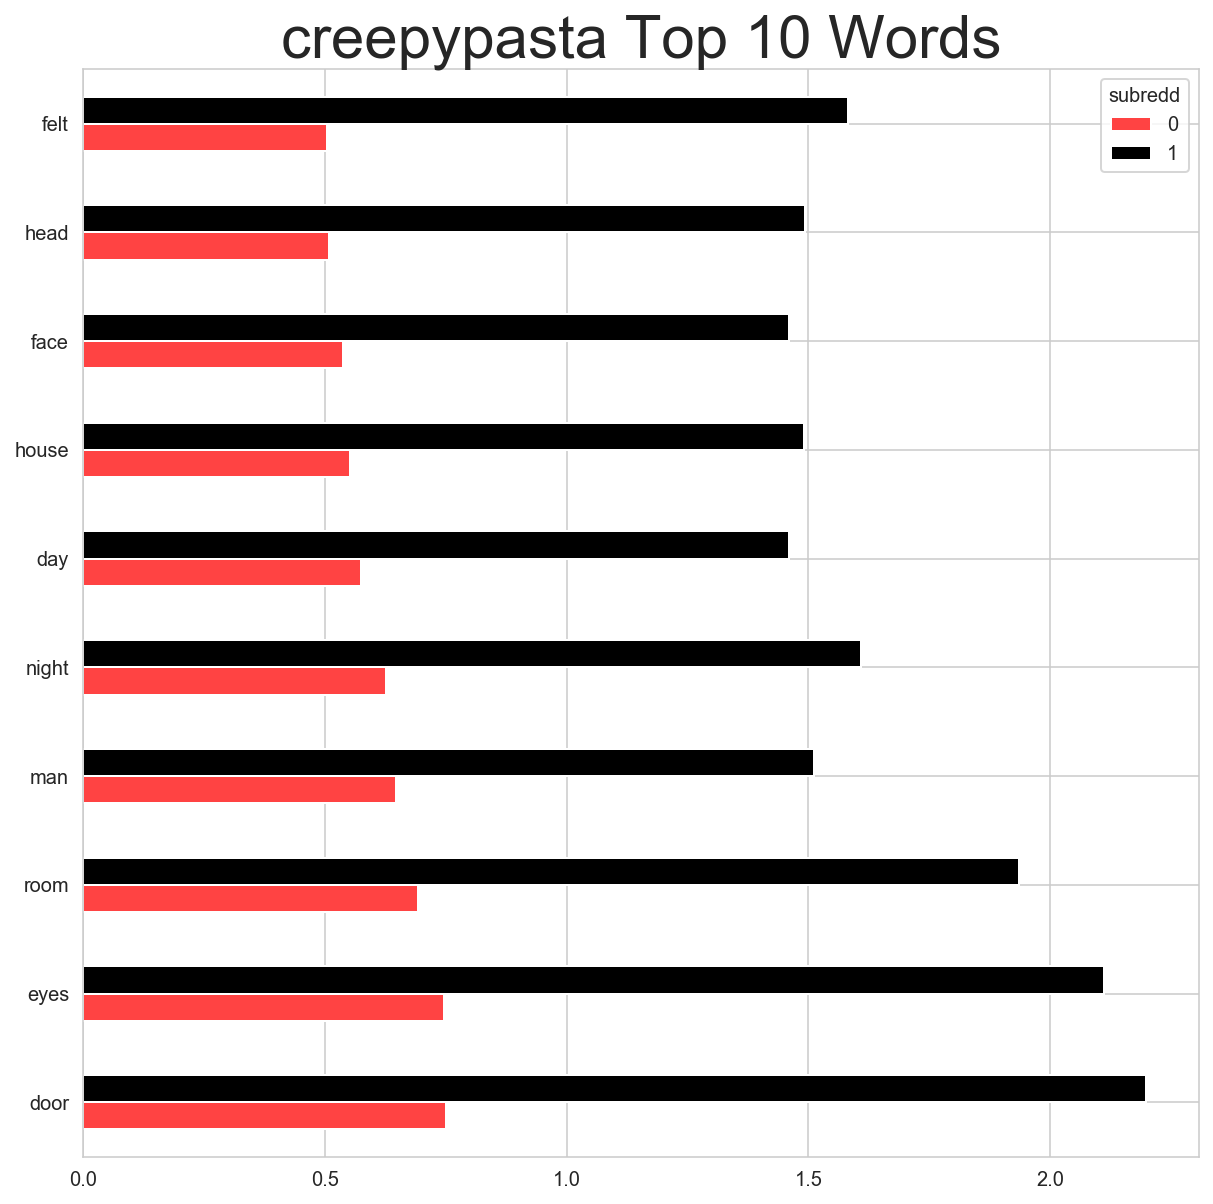

In [94]:
top_words_creepypasta.plot(kind='barh', figsize = (10,10), color = ['#FF4343', 'black'])
plt.title('creepypasta Top 10 Words', fontsize = 30)
plt.savefig('../images/creepypasta_top10.png');

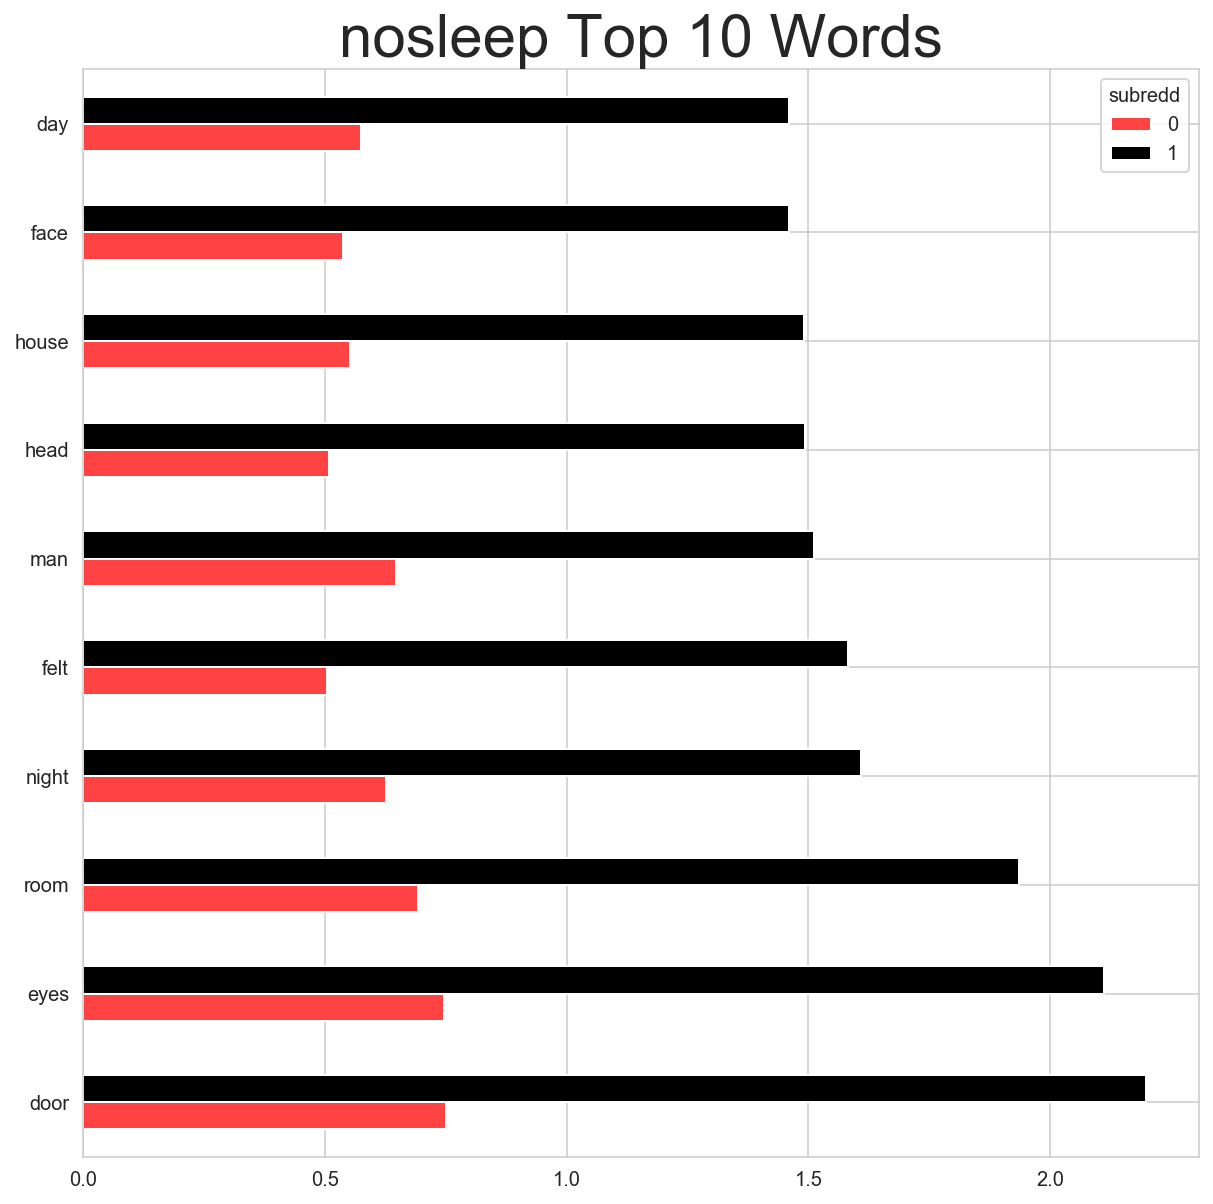

In [103]:
top_words_nosleep.plot(kind='barh', figsize = (10,10), color = ['#FF4343', 'black'])
plt.title('nosleep Top 10 Words', fontsize = 30)
plt.savefig('../images/nosleep_top10.png');

#### Create a list of top 10 words in each subreddit to find  and graph the overlapping words

In [105]:
# top words for creepypasta
top_words_creepypasta_list = list(text_df.groupby('subredd').
     mean().T.sort_values(0, ascending=False).head(20).index)

# top words for nosleep
top_words_nosleep_list = list(text_df.groupby('subredd').
     mean().T.sort_values(1, ascending=False).head(20).index)

# find top overlapping words
top_words_overlap = [scary for scary in top_words_creepypasta_list if scary in top_words_nosleep_list]

print(top_words_overlap)

['door',
 'eyes',
 'room',
 'man',
 'night',
 'day',
 'house',
 'face',
 'head',
 'felt',
 'people',
 'heard',
 'thing',
 'look',
 'little',
 'told',
 'left']

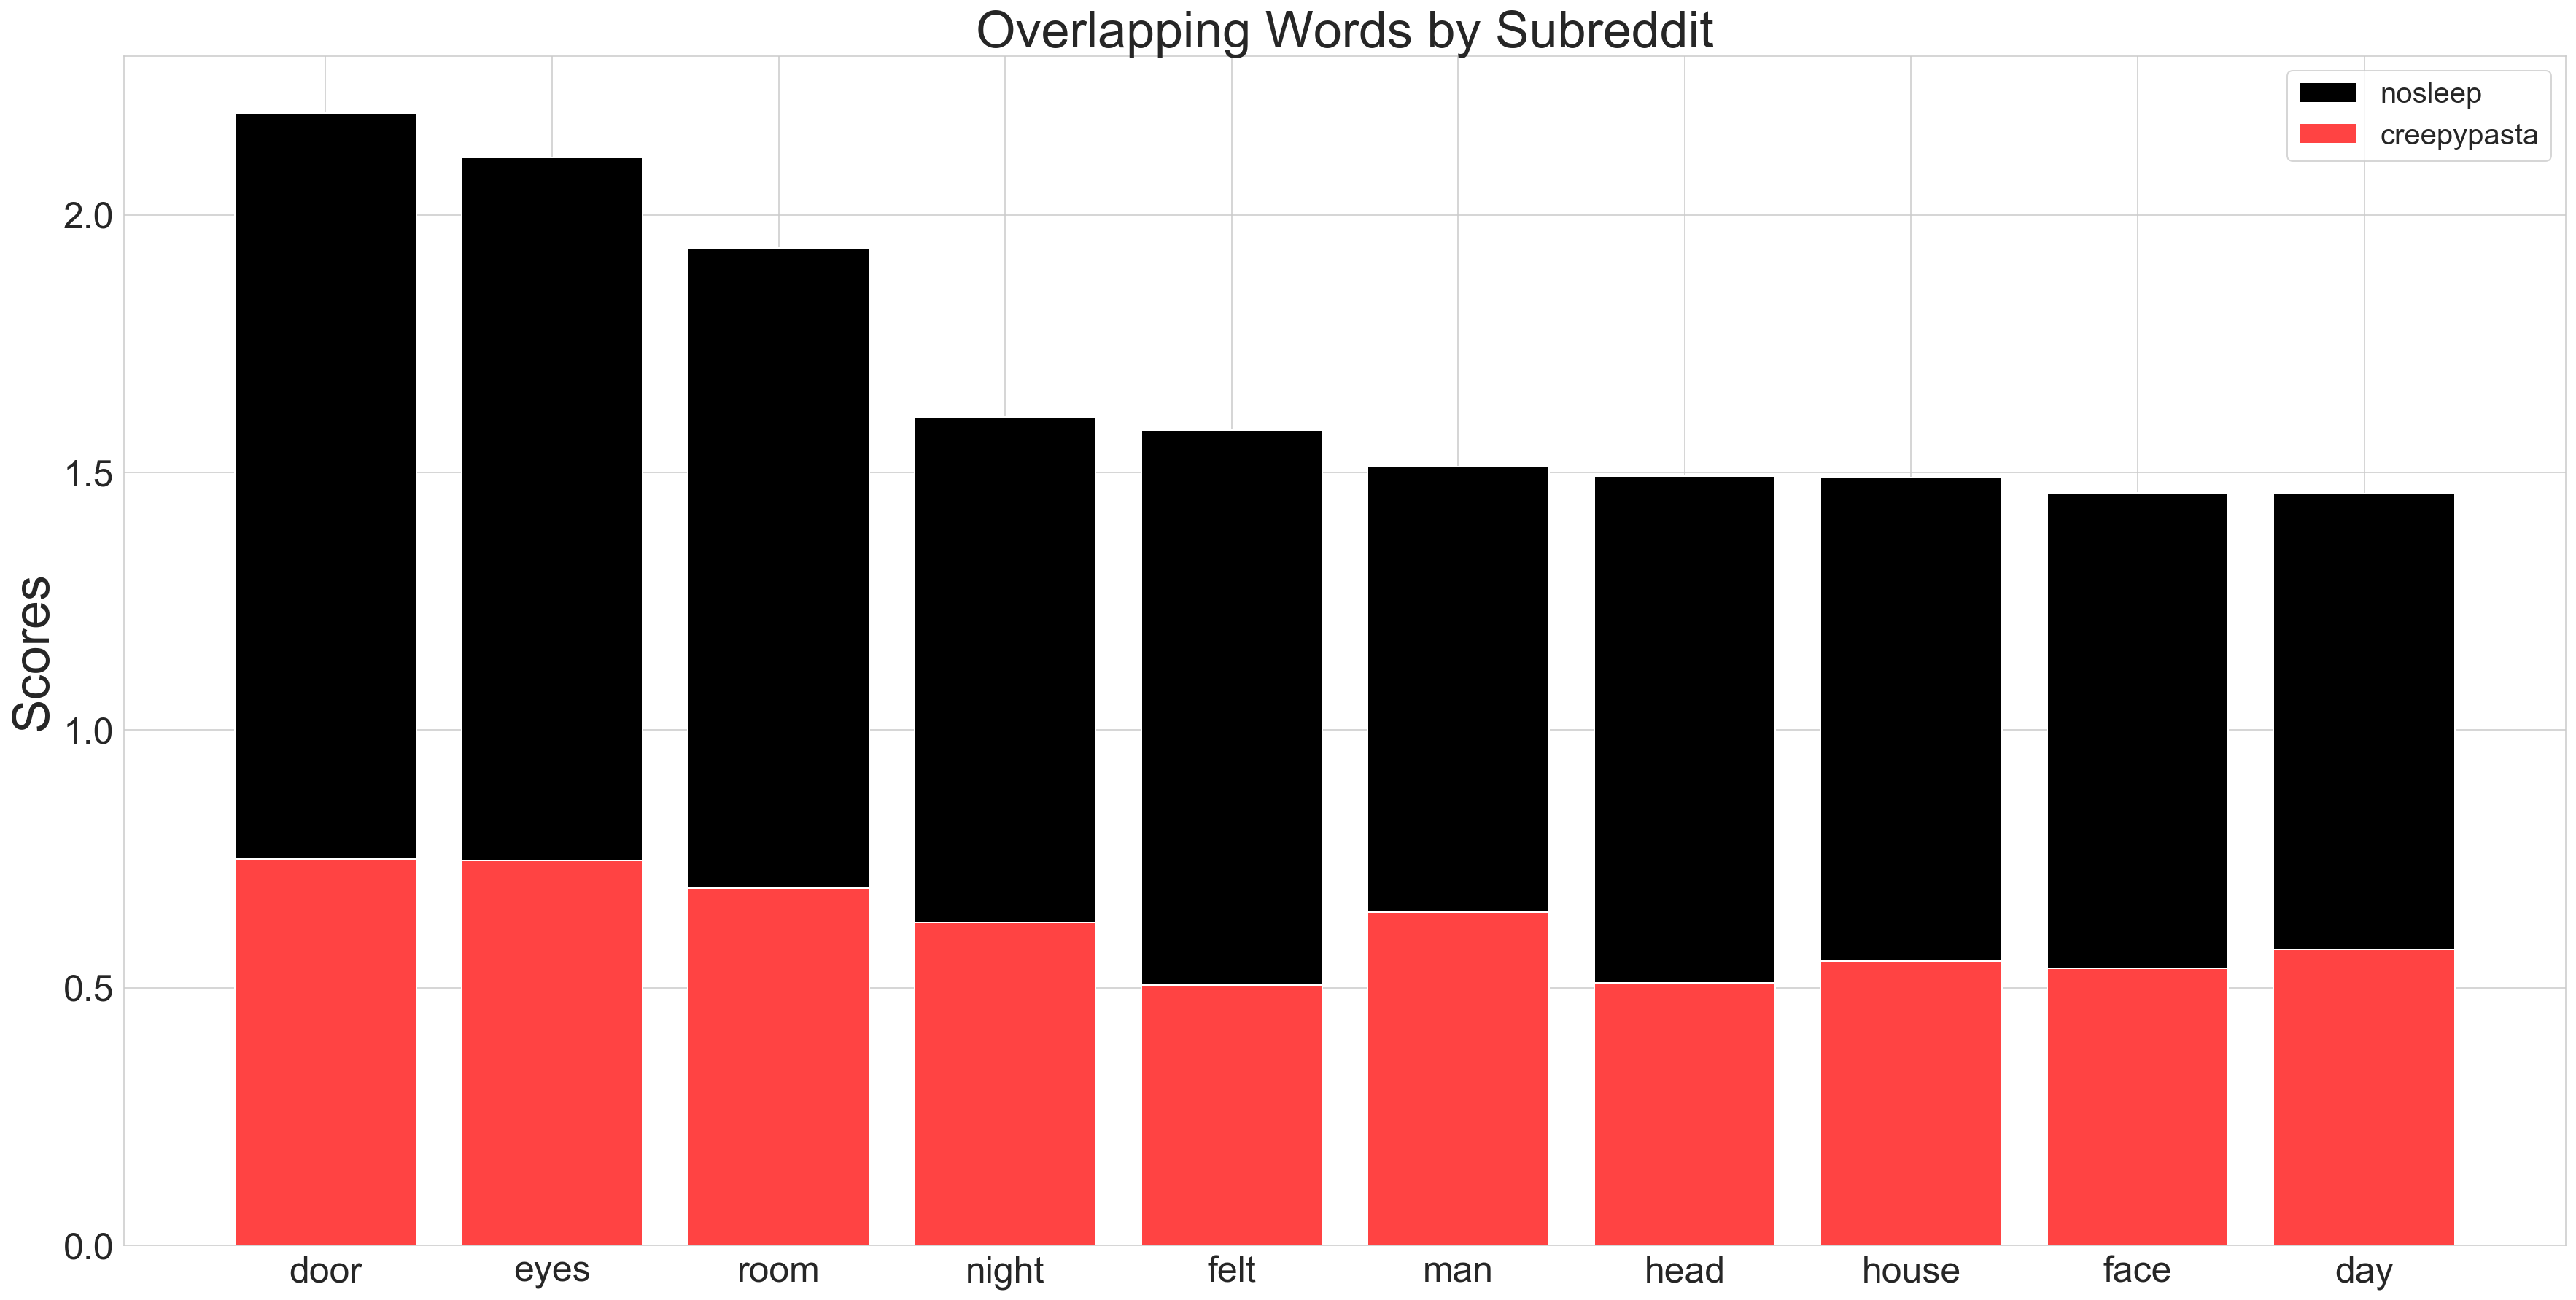

In [100]:
# Graph overlapping words
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
rects1 = ax.bar(top_words_nosleep[1].index, top_words_nosleep[1],color='black')
rects2 = ax.bar(top_words_creepypasta[0].index, top_words_creepypasta[0], color='#FF4343')
ax.set_ylabel('Scores', fontsize = 35)
ax.set_title('Overlapping Words by Subreddit', fontsize = 35)
ax.tick_params(labelsize=25)
ax.legend((rects1[0], rects2[0]), ('nosleep', 'creepypasta'), fontsize =20)
plt.savefig('../images/overlapping_words.png');